In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/CIS 581 F21/Week 4 Homography

/content/drive/MyDrive/CIS 581 F21/Week 4 Homography


In [3]:
'''
import library 
'''
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
!pip install -U opencv-contrib-python==3.4.2.17
import cv2

In [5]:
'''
Function (modify)
'''
def compute_homography(p1, p2):	
  """
  compute the homography transform
  p1, p2: 4 x 2, 4 groups of corresponding points
  """	
  # IMPLEMENT HERE, hint: you may find np.linalg.svd useful
  # print(f"p1.shape[0] = {p1.shape[0]*2}")
  # construct the A matrix in the same way in the slides
  A=[]

  for i in range(p1.shape[0]):
    temp = [[p2[i,0], p2[i,1], 1, 0, 0, 0, -p2[i,0]* p1[i,0] , -p2[i,1]*p1[i,0], -p1[i,0]],
            [ 0, 0, 0, p2[i,0], p2[i,1], 1, -p2[i,0]* p1[i,1] , -p2[i,1]*p1[i,1], -p1[i,1]]]
    A.append(temp[0])
    A.append(temp[1])
  A = np.array(A)
  # A  = np.vstack(p1,p2)
  # use SVD to find the solution to Ax = 0
  u,s,vh = np.linalg.svd(A)
  H = vh.T
  H = H[:,-1] / H[-1,-1]
  H = H.reshape(3,3)
  # reorgnize the solution vector and normalize it to get homography matrix
  return H

In [6]:
## Test ##
p1 = np.array([[366.6972,  106.9789],
  [439.9366,   84.4437],
  [374.5845,  331.2042],
  [428.6690,  326.6972]])

p2 = np.array([ [115.0000,  120.0000],
  [194.0000,  107.0000],
  [109.0000,  351.0000],
  [169.0000,  346.0000] ])
H = compute_homography(p1, p2)

assert np.allclose(H, np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]]))

In [7]:
def plot_corr(I1, I2, p1, p2):
  """
  utility function to plot correspondence between p1 in I1 and p2 in I2

  I1, I2: H * W, two input images of the same size
  p1, p2: N * 2, points on two images 
  """
  I = np.hstack((I1, I2))
  sy,sx = I1.shape[0:2]

  plt.figure()
  plt.imshow(I)
  plt.plot(p1[:, 0], p1[:, 1],'bo')
  plt.plot(sx + p2[:, 0], p2[:, 1],'rx')
  plt.plot(np.c_[p1[:, 0], sx + p2[:, 0]].T, np.c_[p1[:, 1],p2[:, 1]].T, 'g-')
  plt.show()

In [8]:
'''
Function (modify)
'''
def match_features(f1,f2):
  """
  f1, f2: N * feature_size, two features to be matched
  """
  
  # IMPLEMENT HERE
  # hint: you may find cdist from scipy.spatial.distance, numpy.argsort useful

  # compute pairwise distance between f1 and f2
  dist = cdist(f1,f2)
  # print(f"Dist = \n{dist}")
  # forward matching, find closet two matches in f2 to f1 and do a ratio test
  idx = np.argsort(dist, axis = 1)
  # print(f"\nForward Indices \n{idx}")
  # distsort1 = np.take_along_axis(dist, idx, axis=1)
  ratio1 = np.take_along_axis(dist, idx[:,0:1], axis=1) / np.take_along_axis(dist, idx[:,1:2], axis=1)
  
  # print(f"\nFirst Row = \n{np.take_along_axis(dist, idx[:,0:1], axis=1)}\n\nSecond Row = {np.take_along_axis(dist, idx[:,1:2], axis=1)}")
  # print(f"\nRatio = \n{ratio1}")
  
  temphstack = np.hstack((np.arange(f1.shape[0]).reshape((f1.shape[0],1)),idx[:,0:1]))
  
  # print(f"\n\nIndices = \n{temphstack}")
  
  forward_pass = np.asarray((ratio1 < 0.7).nonzero()).T # Returns the indices of values satisfying the condition
  fp_idx = np.asarray((forward_pass[:,0])) #.reshape(len(forward_pass[:,0]),1)
  
  # print(temphstack[fp_idx])
  
  match_fwd = temphstack[fp_idx]


  # backward matching, find closet two matches in f1 to f2 and do a ratio test
  idx2 = np.argsort(dist, axis = 0)
  # print(f"\nBackward\nidx2 = \n{idx2}")
  ratio2 = np.take_along_axis(dist, idx2[0:1,:], axis=0) / np.take_along_axis(dist, idx2[1:2,:], axis=0)
  
  # print(f"\nFirst Row = \n{np.take_along_axis(dist, idx2[0:1,:], axis=0)}\n\nSecond Row = {np.take_along_axis(dist, idx2[1:2,:], axis=0)}")
  # print(f"\nRatio = \n{ratio2}")
  
  # print(idx2.shape)
  temphstack1 = np.hstack ((idx2[0:1,:].reshape((idx2.shape[1],1)),np.arange(f2.shape[0]).reshape((f2.shape[0],1))))
  
  # print(f"Temphstack = {temphstack1}")
  # print(f"\n\nIndices = \n{temphstack}")
  
  backward_pass = np.asarray((ratio2 < 0.7).nonzero()).T # Returns the indices of values satisfying the condition
  # print(f"\nBackwardPass = \n{backward_pass}")
  bk_idx = np.asarray(backward_pass[:,1]) #.reshape(len(forward_pass[:,0]),1)
  
  # print("match_bkwd = \n",temphstack1[bk_idx])
  
  match_bkwd = temphstack1[bk_idx]
  # get the intersect of two matching as the final result, python set 
  # match=np.array([[0, 1],[1, 2]])
  
  match = set(map(tuple, match_fwd)) & set(map(tuple, match_bkwd))
  match = np.array(list(match))
  return match, match_fwd, match_bkwd

In [9]:
## Test ##
a = np.array([[2, 3],[5, 8],[4, 10]])
b = np.array([[10, 2],[2, 3],[5, 7],[1, -10]])
match, match_fwd, match_bkwd = match_features(a, b)
assert np.allclose(match, np.array([[0, 1],[1, 2]]))
assert np.allclose(match_fwd, np.array([[0, 1],[1, 2],[2, 2]]))
assert np.allclose(match_bkwd, np.array([[0, 1],[1, 2]]))

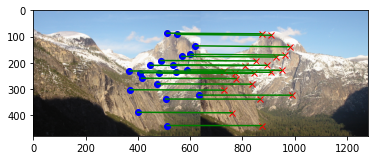

In [10]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

In [11]:
'''
Function (modify)
'''
def ransac_homography_old(p1, p2): # Ignore this, incorrect one
  """
  p1, p2: N * 2, correponding point coordinates
  """
  best_H = np.empty((3,3))
  # IMPLEMENT HERE
  # print(p1.shape, p2.shape)
  # decide how many loops to run and what the threshold is
  p = 1 - 1e-4
  w = 0.5
  n = 4
  loops = (np.log (1-p)) / (np.log(1-(np.power(w,n))))
  print(loops)
  # RANSAC loop, inside in the loop
  #     1. randomly pick n samples from p1 and p2 that is enough to fit a model(n=4 here)

  #     2. fit the model and get a estimation
  best_match = 0
  i = 0
  while i < loops:
    num_pts = np.random.choice(p1.shape)
    rand_ind = np.random.choice(num_pts, n, replace='False')
    p1_sub= p1[rand_ind]
    p2_sub = p2[rand_ind]
    
    H = compute_homography(p1_sub, p2_sub)
    # print(H.shape, p1_sub.shape, p2_sub.shape)
    
    U = H @ np.hstack((p2, np.ones((p2.shape[0],1)))).T
    # print(f"\n U shape =\n {U[:-1,:].T.shape}\nP1.shape = \n{p1.shape}")
    # Distance calc
    # dist = cdist(U,p1)

    match, match_fwd, match_bkwd = match_features(U[:-1,:].T,p1) 
    if len(match)>best_match :
      best_H = H
      best_match = len(match)
    i=i+1

  #     3. count consensus(# of inliners that is close to the estimatiion within the threshold)

  #     4. update the best estimation if the current one is better 
  # best_H=0
  # print(f"\nbest H = {best_H}")
  return best_H

In [12]:
'''
Function (modify)
'''
def ransac_homography(p1, p2):
  """
  p1, p2: N * 2, correponding point coordinates
  """
  
  # IMPLEMENT HERE

  best_H = np.empty((3,3))
  
  # decide how many loops to run and what the threshold is
  
  p = 0.9999
  w = 0.5
  n = 4
  t = 1
  num_inliers = 0
  best_H = None
  best_inliers = None
  loops = (np.log (1-p)) / (np.log(1-(np.power(w,n))))
  # print(loops)

  # RANSAC loop, inside in the loop
  for i in range(np.int(loops)):

  #     1. randomly pick n samples from p1 and p2 that is enough to fit a model(n=4 here)
        random_samples = np.random.choice(np.arange(p1.shape[0]),n)

        p1_temp = p1[random_samples]
        p2_temp = p2[random_samples]

  #     2. fit the model and get a estimation

        H = compute_homography(p1_temp, p2_temp)
        # print(p2_temp.shape)
        p2_temp_withz = np.hstack ((p2, np.ones(p2.shape[0]).reshape((p2.shape[0],1)))) # Run against all values of P2 and not just the 4 points
        
        pred = np.matmul(H, p2_temp_withz.T).T 
        pred = pred /(pred[:,-1].reshape(pred.shape[0],1)) # divide by last column to get column of ones in the end

        pred = pred[:,:-1] # Remove the last column

  #     3. count consensus(# of inliners that is close to the estimatiion within the threshold)
        # print(pred.shape)
        dist = np.sqrt (np.sum(np.subtract(p1,pred)**2, axis=1))
        num_inliers = np.sum(dist < t)
        # print(num_inliers)
        if (best_inliers == None) or (num_inliers > best_inliers) :
          best_H = H
          best_inliers = num_inliers
          # print(best_inliers)

  #     4. update the best estimation if the current one is better 
  return best_H

In [13]:
## Test ##
p2 = np.random.randint(20, 200, size=(10, 2))
p2_ = np.hstack((p2, np.ones((10, 1)))).T
H = np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]])
p1_ = H @ p2_
p1 = p1_ / p1_[-1, :]
p1 = p1[:2]
p1[:, -1] += 50
p1 = p1.T
assert np.allclose(H, ransac_homography(p1, p2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


In [14]:
"""
Function (do not modify)
"""
def stitch_cv(I1, I2, H):
    """
    utility function to stitch two images

    Input:

    I1: H1 x W1 x 3, target image
    I2: H2 x W2 x 3, source image
    H: homography matrix such that I1 = H @ I2

    Output:
    I_: stitching result
    """
    
    # map I2 to I1
    width = I1.shape[1] + I2.shape[1]
    height = max(I1.shape[0] ,I2.shape[0])
    # create new dimensions to accomodate points from I2
    print(I2.shape)
    print(H.shape)
    I_ = cv2.warpPerspective(I2, H, (width,height))
    I_[0:I1.shape[0], 0:I1.shape[1]] = I1
    # create images I_ for mapping

    # map I_ to I2 (translation then homography)

    # keep only the valid coordinates of I2

    # in blend area, take the average of I1_ and I2_
    
    return I_

In [15]:
def interp2(v, xq, yq):
	dim_input = 1
	if len(xq.shape) == 2 or len(yq.shape) == 2:
		dim_input = 2
		q_h = xq.shape[0]
		q_w = xq.shape[1]
		xq = xq.flatten()
		yq = yq.flatten()

	h = v.shape[0]
	w = v.shape[1]
	if xq.shape != yq.shape:
		raise 'query coordinates Xq Yq should have same shape'

	x_floor = np.floor(xq).astype(np.int32)
	y_floor = np.floor(yq).astype(np.int32)
	x_ceil = np.ceil(xq).astype(np.int32)
	y_ceil = np.ceil(yq).astype(np.int32)

	x_floor[x_floor < 0] = 0
	y_floor[y_floor < 0] = 0
	x_ceil[x_ceil < 0] = 0
	y_ceil[y_ceil < 0] = 0

	x_floor[x_floor >= w-1] = w-1
	y_floor[y_floor >= h-1] = h-1
	x_ceil[x_ceil >= w-1] = w-1
	y_ceil[y_ceil >= h-1] = h-1

	v1 = v[y_floor, x_floor]
	v2 = v[y_floor, x_ceil]
	v3 = v[y_ceil, x_floor]
	v4 = v[y_ceil, x_ceil]

	lh = yq - y_floor
	lw = xq - x_floor
	hh = 1 - lh
	hw = 1 - lw

	w1 = hh * hw
	w2 = hh * lw
	w3 = lh * hw
	w4 = lh * lw

	interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

	if dim_input == 2:
		return interp_val.reshape(q_h, q_w)
	return interp_val

In [16]:
"""
Function (do not modify)
"""
def stitch_old(I1, I2, H):
    """
    utility function to stitch two images

    Input:

    I1: H1 x W1 x 3, target image
    I2: H2 x W2 x 3, source image
    H: homography matrix such that I1 = H @ I2

    Output:
    I_: stitching result
    """
    
    # map I2 to I1
    x,y = np.meshgrid(np.arange(I2.shape[1]), np.arange(I2.shape[0]))
    x = x.flatten().reshape(x.shape[0]*x.shape[1],1)
    y = y.flatten().reshape(y.shape[0]*y.shape[1],1)
    I2_coord = np.hstack((x,y,np.ones((x.shape[0],1))))
    
    
    y1,x1 = np.meshgrid(np.arange(I1.shape[0]), np.arange(I1.shape[1]))
    x1 = x1.flatten().reshape(x1.shape[0]*x1.shape[1],1)
    y1 = y1.flatten().reshape(y1.shape[0]*y1.shape[1],1)
    I1_coord = np.hstack((x1,y1,np.ones((x1.shape[0],1)))) 
    
    I2_in_I1 = np.matmul(H, I2_coord.T).T

    I2_in_I1 = I2_in_I1 / (I2_in_I1[:,-1][...,None])

    # print(f"\n\nStitch\n I2_coord = \n{I2_coord}")
    # create new dimensions to accomodate points from I2
    # print(min(np.min(I1_coord[:,0]), np.min(I2_in_I1[:,0])))

    I2_in_I1_max = np.max(I2_in_I1, axis=0)

    I2_in_I1_max_x = I2_in_I1_max[0]
    I2_in_I1_max_y = I2_in_I1_max[1]

    I1_coord_max = np.max(I1_coord, axis=0)

    I1_coord_max_y = I1_coord_max[1]
    I1_coord_max_x = I1_coord_max[0]

    I2_in_I1_min = np.min(I2_in_I1, axis=0)

    I2_in_I1_min_x = I2_in_I1_min[0]
    I2_in_I1_min_y = I2_in_I1_min[1]

    I1_coord_min = np.min(I1_coord, axis=0)

    I1_coord_min_y = I1_coord_min[1]
    I1_coord_min_x = I1_coord_min[0]
    
    # print(I2_in_I1_min_x, I2_in_I1_min_y,I1_coord_min_x, I1_coord_min_y )

    # print(I2_in_I1_max_x, I2_in_I1_max_y,I1_coord_max_x, I1_coord_max_y )

    I_max_x = max(I2_in_I1_max_x, I1_coord_max_x)
    I_max_y = max(I2_in_I1_max_y, I1_coord_max_y)
    I_min_x = min(I2_in_I1_min_x, I1_coord_min_x)
    I_min_y = min(I2_in_I1_min_y, I1_coord_min_y)

    I_max_x = int(I_max_x) 
    I_max_y = int(I_max_y)
    I_min_x = int(I_min_x)
    I_min_y = int(I_min_y)

    print(f"\n Final Coordinates are : \n Max X = {I_max_x}\n Max Y = {I_max_y}\n Min X = {I_min_x}\n Min Y = {I_min_y}")

    # create images I_ for mapping
    x_final, y_final = np.meshgrid(np.arange(I_min_x,I_max_x), np.arange(I_min_y, I_max_y))
    # I_I1 = np.zeros((I_max_y - I_min_y,I_max_x - I_min_x,3)) # Created the final image matrix
    
    I_I1 = np.zeros((x_final.shape[0],x_final.shape[1]))
    
    print(I_I1.shape)
    I_I2 = I_I1
    # map I_ to I2 (translation then homography)
    
    # print(f"\nI1.shape = \n{I1.shape[0]}\n{I1.shape[1]}")
    # I_[0:I1.shape[0], 0:I1.shape[1],:] = I1
    I_I1[-I_min_y:-I_min_y+I1.shape[0], -I_min_x:-I_min_x+I1.shape[1],:] = I1 # Image 1 is placed in the final image
    
    # keep only the valid coordinates of I2
    # I_[I_.shape[0]-I2.shape[0]:, I_.shape[1]-I2.shape[1]:, : ] = I2

    # obtaining the coordinates of Final Image
    x,y = np.meshgrid(np.arange(I_I2.shape[1]), np.arange(I_I2.shape[0]))
    x = x.flatten().reshape(x.shape[0]*x.shape[1],1)
    y = y.flatten().reshape(y.shape[0]*y.shape[1],1)
    I_I2_coord = np.hstack((x,y,np.ones((x.shape[0],1))))
    
    H_inv = np.inv(H)

    I_I2_in_I2 = np.matmul(H_inv, I_I2_coord.T).T 
    I1_copy_in_I2 = I1_copy_in_I2 / (I1_copy_in_I2[:,-1][...,None])

    I_I2[:, :, 0] = np.reshape
    # u_x = H(1,1)*v_x + H(1,2)*v_y + H(1,3);
    # u_y = H(2,1)*v_x + H(2,2)*v_y + H(2,3);
    # im_warped(:,:,1) = reshape(interp2(im(:,:,1), u_x(:), u_y(:)), [h, w]);
    # im_warped(:,:,2) = reshape(interp2(im(:,:,2), u_x(:), u_y(:)), [h, w]);
    # im_warped(:,:,3) = reshape(interp2(im(:,:,3), u_x(:), u_y(:)), [h, w]);
    # in blend area, take the average of I1_ and I2_
    # I_=0
    I_ = np.uint8(I_)
    return I_

In [17]:
"""
Function (do not modify)
"""
def stitch(I1, I2, H):
    """
    utility function to stitch two images

    Input:

    I1: H1 x W1 x 3, target image
    I2: H2 x W2 x 3, source image
    H: homography matrix such that I1 = H @ I2

    Output:
    I_: stitching result
    """
    
    # map I2 to I1
    
    y_i2, x_i2 = I2.shape[:2]
    
    # Obtain corners of I2
    
    I2_corner1 = np.ones(3)
    I2_corner2 = np.ones(3)
    I2_corner3 = np.ones(3)
    I2_corner4 = np.ones(3)

    I2_corner1[:2] = [0,0]
    I2_corner2[:2] = [0,y_i2]
    I2_corner3[:2] = [x_i2,0]
    I2_corner4[:2] = [x_i2,y_i2]

    max_x = None
    max_y = None
    min_x = None
    min_y = None

    # Homography of corner points
    for point in [I2_corner1,I2_corner2,I2_corner3,I2_corner4]:

      I2_H = np.matmul(H, np.array(point).T)

      I2_H = I2_H / I2_H[2]
      
      I2_H = I2_H[:2]
      I2_H = np.array(I2_H).reshape(I2_H.shape[0],1)
      if ( max_x == None or I2_H[0,0] > max_x ):
        max_x = I2_H[0,0]
      
      if ( max_y == None or I2_H[1,0] > max_y ):
        max_y = I2_H[1,0]
      
      if ( min_x == None or I2_H[0,0] < min_x ):
        min_x = I2_H[0,0]
      
      if ( min_y == None or I2_H[1,0] < min_y ):
        min_y = I2_H[1,0]
      
    min_x = min(0, min_x)
    min_y = min(0, min_y)
    
    print(f"Min_x = {min_x}\nMax_x = {max_x}\nMin_y = {min_y}\nMax_y = {max_y}") # Correct!

    min_x = int(min_x)
    min_y = int(min_y)
    max_x = int(max_x)
    max_y = int(max_y)

    I_I1 = np.zeros((max_y-min_y, max_x-min_x, 3))
    I_I2 = I_I1
    I_ = I_I1
    print(f"I_I1.shape = {I_I1.shape}")
    # Translation Matrix
    T = np.array([[1 , 0 , min_x],
                  [0 , 1 , min_y],
                  [0 , 0 , 1    ]])
    
    # Put all values of I1 in the final version 

    I_I1[abs(min_y) : abs(min_y) + I1.shape[0], abs(min_x) : abs(min_x) + I1.shape[1], :] = I1
    
    # Make the coordinate matrix of Final image 

    y_I_I2, x_I_I2 = I_I2.shape[:2]

    y_range = np.arange(y_I_I2)
    x_range = np.arange(x_I_I2)

    y_grid, x_grid = np.meshgrid(y_range,x_range)

    y_grid_flatten = y_grid.flatten()
    x_grid_flatten = x_grid.flatten()
    print(y_grid_flatten.shape[0], x_grid_flatten[0].shape)
    y_grid_flatten = y_grid_flatten.reshape(y_grid_flatten.shape[0],1) 
    x_grid_flatten = x_grid_flatten.reshape(x_grid_flatten.shape[0],1)


    I_I2_coord = np.hstack((x_grid_flatten, y_grid_flatten, np.ones((x_grid_flatten.shape[0],1))))

    I_inter = np.matmul(T, I_I2_coord.T) 

    H_inv = np.linalg.inv(H)
    I_I2_hat = np.matmul(H_inv, I_inter)

    I_I2_hat = I_I2_hat / (I_I2_hat[2,:]) # Normalized

    I_I2_hat = I_I2_hat[:2,:].T # Removed third row

    x_I_I2_hat = I_I2_hat[:,0]
    y_I_I2_hat = I_I2_hat[:,1]
    
    in_points = np.where((x_I_I2_hat > 0) & (x_I_I2_hat < I2.shape[1]) & (y_I_I2_hat > 0) & (y_I_I2_hat < I2.shape[0]))

    x_I_I2_hat = x_I_I2_hat[in_points]
    y_I_I2_hat = y_I_I2_hat[in_points]

    y_grid_flatten = y_grid_flatten[in_points]
    x_grid_flatten = x_grid_flatten[in_points]

    I2_interp2 = np.zeros((x_grid_flatten.shape[0],3))
    I2_interp2[:,0] = interp2(I2[:,:,0], x_I_I2_hat, y_I_I2_hat)
    I2_interp2[:,1] = interp2(I2[:,:,1], x_I_I2_hat, y_I_I2_hat)
    I2_interp2[:,2] = interp2(I2[:,:,2], x_I_I2_hat, y_I_I2_hat)

    for i in range(x_I_I2_hat.shape[0]):
      if (I_I1[y_grid_flatten[i], x_grid_flatten[i],:].all() == 0):
        I_I1[y_grid_flatten[i], x_grid_flatten[i],:] = I2_interp2[i]
      else:
        I_I1[y_grid_flatten[i], x_grid_flatten[i],:] =(I_I1[y_grid_flatten[i], x_grid_flatten[i],:] + I2_interp2[i]) / 2

    return I_I1/255  


    # create new dimensions to accomodate points from I2

    # create images I_ for mapping

    # map I_ to I2 (translation then homography)

    # keep only the valid coordinates of I2

    # in blend area, take the average of I1_ and I2_
    # I_I1 = np.uint8(I_I1)
    # return I_I1

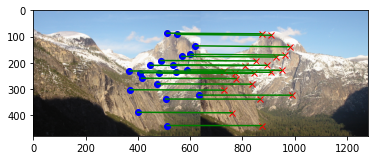

[[ 9.43035753e-01  9.63153484e-03  2.79568221e+02]
 [-2.36097486e-02  9.95182716e-01  9.44991117e-01]
 [-9.38181224e-05  1.52119473e-05  1.00000000e+00]]
Min_x = 0
Max_x = 939.5234724096982
Min_y = -15.070111750442281
Max_y = 489.33066709333383
I_I1.shape = (504, 939, 3)
473256 ()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


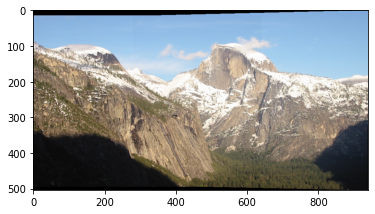

In [18]:

"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

# estimate homography transform with RANSAC
H = ransac_homography(p1, p2)
print(H)
# stitch two images together and show the results
I = stitch(I1,I2,H)
plt.figure()
plt.imshow(I)
plt.show()